## Bare pretrained Resnet backbone evaluation

In [40]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import os
from torchsummary import summary
import numpy as np
from torch.nn import functional as F

BATCH = 32
label_names = ["D", "G", "A"]
device = "cuda" if torch.cuda.is_available() else "cpu"
efficientnet_dir = "../pretrained_backbone/ckpt_efficientnet_ep50.pt"

In [41]:
train_images= "../images/train"
train_labels = "../train.csv"
val_images = "../images/val"
val_labels = "../val.csv"
offsite_test_images = "../images/offsite_test"
offsite_test_labels = "../offsite_test.csv"
onsite_test_images = "../images/onsite_test"
onsite_test_labels = "../onsite_test_submission.csv"

### Uncomment on colab

In [42]:

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Projects/ODIR/task2_loss")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Datasets

In [43]:
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels

### Image transform

In [44]:
img_size=256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [45]:
train = RetinaMultiLabelDataset(train_labels, train_images, transform = transform)
val = RetinaMultiLabelDataset(val_labels, val_images, transform = transform)
offsite_test = RetinaMultiLabelDataset(offsite_test_labels, offsite_test_images, transform = transform)
onsite_test = RetinaMultiLabelDataset(onsite_test_labels, onsite_test_images, transform = transform)


### Model

In [46]:

class Classifier(nn.Module):
    def __init__(self, backbone = "resnet", dir = None):
        super().__init__()

        if dir == None:
            raise FileNotFoundError
        layers = torch.load(dir)

        if backbone == "resnet":
            self.model = models.resnet18()
            self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        elif backbone == "efficientnet":
            self.model = models.efficientnet_b0()
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 3)
        else:
            raise ValueError("Unsupported backbone")
        self.model.load_state_dict(layers)

    def forward(self, X):
        return self.model(X)

model = Classifier(backbone="efficientnet", dir=efficientnet_dir).to(device)

In [47]:
def eval_model(model, dataset, csv_file = None, report = False):

    loader = DataLoader(dataset, BATCH, shuffle=False)
    preds = []
    model.eval()

    with torch.no_grad():
      for X, _ in tqdm(loader):
          output = (nn.functional.sigmoid(model(X.to(device))) > 0.5).long()
          preds.extend(output.cpu().numpy())

    preds = np.stack(preds)
    if report:
        cr = classification_report(dataset.data[label_names].to_numpy(), preds, target_names=label_names, zero_division= np.nan)
        print(cr)
    if csv_file:
        data = dataset.data.copy()
        data[label_names] = preds
        data.to_csv(csv_file, index = False)

## Fine-tuning classifier first

In [48]:
params = model.parameters()
for layer in params:
  layer.requires_grad = False
for param in model.model.classifier[1].parameters():
  param.requires_grad = True

In [49]:
checkpoints_dir = "../trained_models/"


def train_model(model, train_data, eval_data, optimizer, criterion, epochs, stepLR = None, checkpoint_name = None):
    train_loader = DataLoader(train_data,  BATCH, shuffle=True)
    val_loader = DataLoader(eval_data, BATCH, shuffle=False)
    train_size = len(train_data.data)
    eval_size = len(eval_data.data)

    train_losses = []
    val_losses = []

    f1 = []
    accuracy = []
    best_score = np.inf
    for i in range(epochs):
        model.train()
        train_loss = 0
        val_loss = 0
        val_f1 = 0
        val_accuracy = 0

        for (X, Y) in tqdm(train_loader, desc = "Training"):
            if device == "cuda":
                X = X.to(device)
                Y = Y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)

        train_loss = train_loss / train_size

        model.eval()
        with torch.no_grad():
            for (X, Y) in tqdm(val_loader, desc="Validation"):
                if device == "cuda":
                    X = X.to(device)
                    Y = Y.to(device)
                output = model(X)
                loss = criterion(output, Y)
                val_loss += loss.item() * X.size(0)
                output = nn.functional.sigmoid(output)
                val_accuracy += accuracy_score((output > 0.5).cpu().long().numpy(), Y.cpu().numpy())
                val_f1 += f1_score((output > 0.5).cpu().long().numpy(), Y.cpu().numpy(),average='samples')

        val_loss = val_loss / eval_size
        val_accuracy /= np.ceil(eval_size/BATCH)
        val_f1 /= np.ceil(eval_size/BATCH)

        print(f"Epoch: {i} - Train Loss: {train_loss:2f} - Val Loss: {val_loss:2f} - Val Accuracy: {val_accuracy:2f} - Val F1 (avg. samples): {val_f1:2f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        #saving model if score imporved
        if best_score > val_loss :
            print("✅ Model improved! Saving if checkpoint_name is set.")
            best_score = val_loss
            if checkpoint_name != None:
                torch.save(model.state_dict(), checkpoints_dir + checkpoint_name)
        f1.append(val_f1)
        accuracy.append(val_accuracy)
        if stepLR != None:
                stepLR.step()

    x = range(0, epochs)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, train_losses, label = "Train Loss")
    plt.plot(x, val_losses, label = "Val Loss")
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("BCE Loss")
    plt.subplot(1, 3, 2)
    plt.plot(x, f1)
    plt.title("Val F1 (avg. samples)")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.subplot(1, 3, 3)
    plt.plot(x, accuracy)
    plt.title("Val accuracy")
    plt.ylabel("Metric")
    plt.xlabel("Epoch")
    plt.show()

    return train_losses, val_losses, f1, accuracy

In [50]:
class ClassBalancedLoss(nn.Module):

    def __init__(self, dataset):
        super().__init__()
        assert dataset is not None, "You must provide the training dataset."

        pos = dataset.data[label_names].sum(axis = 0).to_numpy()
        neg = len(train.data) - pos
        self.weights = torch.tensor(neg / pos,  dtype=torch.float32, device=device)

    def forward(self, inputs, targets):
        return F.binary_cross_entropy_with_logits(inputs, targets, weight=self.weights, reduction="mean")

lr=1e-3 was the best <br>
gamma=0.6 for the StepLR works really good!

Validation: 100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


Epoch: 0 - Train Loss: 1.744032 - Val Loss: 1.622285 - Val Accuracy: 0.348214 - Val F1 (avg. samples): 0.471726
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch: 1 - Train Loss: 1.193921 - Val Loss: 1.436716 - Val Accuracy: 0.526786 - Val F1 (avg. samples): 0.660714
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]


Epoch: 2 - Train Loss: 1.091402 - Val Loss: 1.449903 - Val Accuracy: 0.571429 - Val F1 (avg. samples): 0.675595


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


Epoch: 3 - Train Loss: 1.078487 - Val Loss: 1.326647 - Val Accuracy: 0.580357 - Val F1 (avg. samples): 0.693452
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.95it/s]


Epoch: 4 - Train Loss: 1.039026 - Val Loss: 1.270964 - Val Accuracy: 0.580357 - Val F1 (avg. samples): 0.693452
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]


Epoch: 5 - Train Loss: 1.026111 - Val Loss: 1.254888 - Val Accuracy: 0.593750 - Val F1 (avg. samples): 0.691964
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


Epoch: 6 - Train Loss: 1.020622 - Val Loss: 1.282236 - Val Accuracy: 0.593750 - Val F1 (avg. samples): 0.700893


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


Epoch: 7 - Train Loss: 0.961072 - Val Loss: 1.225459 - Val Accuracy: 0.598214 - Val F1 (avg. samples): 0.699405
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


Epoch: 8 - Train Loss: 0.957654 - Val Loss: 1.239360 - Val Accuracy: 0.593750 - Val F1 (avg. samples): 0.697917


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


Epoch: 9 - Train Loss: 0.931021 - Val Loss: 1.196876 - Val Accuracy: 0.602679 - Val F1 (avg. samples): 0.697917
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.42it/s]


Epoch: 10 - Train Loss: 0.958687 - Val Loss: 1.186446 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.693452
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Epoch: 11 - Train Loss: 0.960839 - Val Loss: 1.216743 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.706845


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.11it/s]


Epoch: 12 - Train Loss: 0.907244 - Val Loss: 1.228893 - Val Accuracy: 0.598214 - Val F1 (avg. samples): 0.699405


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


Epoch: 13 - Train Loss: 0.883165 - Val Loss: 1.220367 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.705357


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.64it/s]


Epoch: 14 - Train Loss: 0.863124 - Val Loss: 1.196882 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.705357


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


Epoch: 15 - Train Loss: 0.924964 - Val Loss: 1.176299 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.708333
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.16it/s]


Epoch: 16 - Train Loss: 0.887656 - Val Loss: 1.189538 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.705357


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


Epoch: 17 - Train Loss: 0.891049 - Val Loss: 1.173423 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.706845
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.18it/s]


Epoch: 18 - Train Loss: 0.861813 - Val Loss: 1.226689 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.712798


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


Epoch: 19 - Train Loss: 0.875288 - Val Loss: 1.189678 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.699405


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


Epoch: 20 - Train Loss: 0.865382 - Val Loss: 1.178607 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.708333


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch: 21 - Train Loss: 0.863621 - Val Loss: 1.174371 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.708333


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


Epoch: 22 - Train Loss: 0.841503 - Val Loss: 1.200471 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.703869


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]


Epoch: 23 - Train Loss: 0.867104 - Val Loss: 1.166957 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.705357
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


Epoch: 24 - Train Loss: 0.834168 - Val Loss: 1.167623 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.709821


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


Epoch: 25 - Train Loss: 0.859625 - Val Loss: 1.187797 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.702381


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


Epoch: 26 - Train Loss: 0.846891 - Val Loss: 1.153174 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.706845
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


Epoch: 27 - Train Loss: 0.826784 - Val Loss: 1.183466 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.712798


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


Epoch: 28 - Train Loss: 0.830771 - Val Loss: 1.163583 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.712798


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


Epoch: 29 - Train Loss: 0.841970 - Val Loss: 1.169504 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.705357


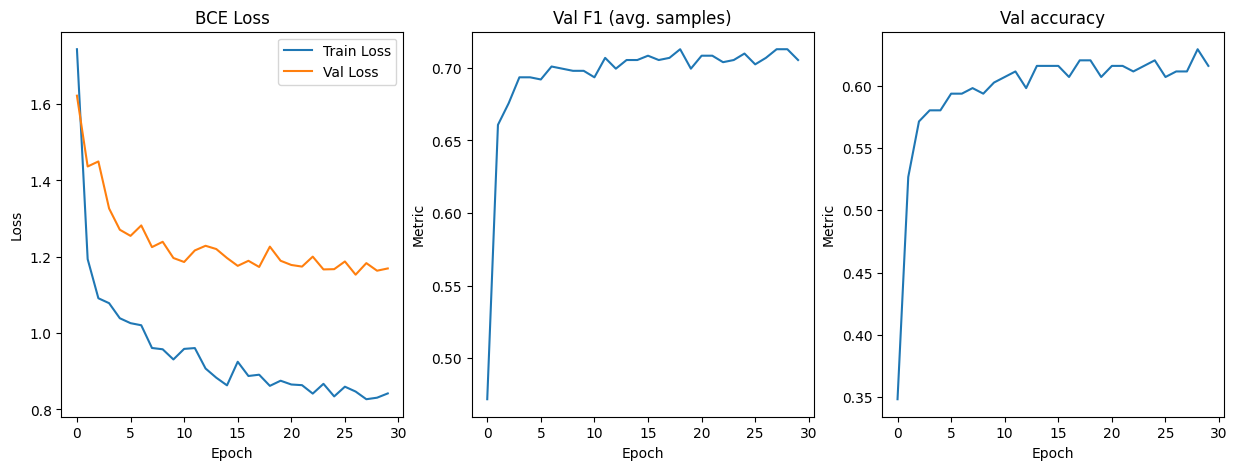

Validation: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch: 0 - Train Loss: 0.841010 - Val Loss: 1.216565 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.717262
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Epoch: 1 - Train Loss: 0.840053 - Val Loss: 1.143428 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.717262
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


Epoch: 2 - Train Loss: 0.807287 - Val Loss: 1.172948 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.724702


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


Epoch: 3 - Train Loss: 0.849543 - Val Loss: 1.165527 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.721726


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


Epoch: 4 - Train Loss: 0.787470 - Val Loss: 1.174032 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.706845


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


Epoch: 5 - Train Loss: 0.787832 - Val Loss: 1.194254 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.708333


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


Epoch: 6 - Train Loss: 0.832820 - Val Loss: 1.151991 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.727679


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.57it/s]


Epoch: 7 - Train Loss: 0.798430 - Val Loss: 1.171323 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.712798


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


Epoch: 8 - Train Loss: 0.796027 - Val Loss: 1.125889 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.718750
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.36it/s]


Epoch: 9 - Train Loss: 0.770733 - Val Loss: 1.152908 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.717262


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


Epoch: 10 - Train Loss: 0.818461 - Val Loss: 1.120984 - Val Accuracy: 0.602679 - Val F1 (avg. samples): 0.712798
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]


Epoch: 11 - Train Loss: 0.803965 - Val Loss: 1.159804 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.729167


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


Epoch: 12 - Train Loss: 0.771616 - Val Loss: 1.142559 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.718750


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]


Epoch: 13 - Train Loss: 0.772540 - Val Loss: 1.158787 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.717262


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch: 14 - Train Loss: 0.757336 - Val Loss: 1.121974 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.711310


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]


Epoch: 15 - Train Loss: 0.771321 - Val Loss: 1.178054 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.715774


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


Epoch: 16 - Train Loss: 0.743930 - Val Loss: 1.119514 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.733631
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch: 17 - Train Loss: 0.716482 - Val Loss: 1.147300 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.705357


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


Epoch: 18 - Train Loss: 0.771287 - Val Loss: 1.129100 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.727679


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.12it/s]


Epoch: 19 - Train Loss: 0.763469 - Val Loss: 1.137538 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.715774


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.66it/s]


Epoch: 20 - Train Loss: 0.742503 - Val Loss: 1.151691 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.726190


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]


Epoch: 21 - Train Loss: 0.745127 - Val Loss: 1.121367 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.726190


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]


Epoch: 22 - Train Loss: 0.729338 - Val Loss: 1.150101 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.709821


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.35it/s]


Epoch: 23 - Train Loss: 0.739879 - Val Loss: 1.131138 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.726190


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


Epoch: 24 - Train Loss: 0.727601 - Val Loss: 1.128563 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.727679


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


Epoch: 25 - Train Loss: 0.757469 - Val Loss: 1.144440 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.727679


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


Epoch: 26 - Train Loss: 0.740759 - Val Loss: 1.142946 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.721726


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


Epoch: 27 - Train Loss: 0.736490 - Val Loss: 1.156605 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.714286


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch: 28 - Train Loss: 0.702815 - Val Loss: 1.138712 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.733631


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


Epoch: 29 - Train Loss: 0.728984 - Val Loss: 1.152268 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.721726


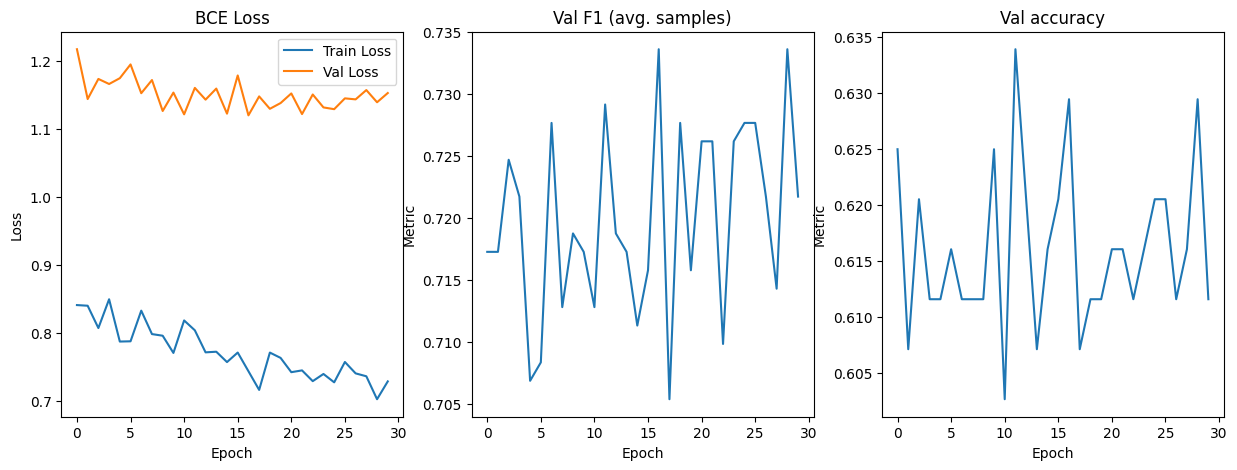

Validation: 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


Epoch: 0 - Train Loss: 0.746006 - Val Loss: 1.115779 - Val Accuracy: 0.602679 - Val F1 (avg. samples): 0.694940
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


Epoch: 1 - Train Loss: 0.736401 - Val Loss: 1.200119 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.718750


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


Epoch: 2 - Train Loss: 0.761162 - Val Loss: 1.117971 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.724702


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


Epoch: 3 - Train Loss: 0.756771 - Val Loss: 1.160159 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.726190


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


Epoch: 4 - Train Loss: 0.720451 - Val Loss: 1.150626 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.726190


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


Epoch: 5 - Train Loss: 0.738768 - Val Loss: 1.138235 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.717262


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]


Epoch: 6 - Train Loss: 0.730721 - Val Loss: 1.108189 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.727679
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


Epoch: 7 - Train Loss: 0.731739 - Val Loss: 1.208088 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.726190


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch: 8 - Train Loss: 0.753384 - Val Loss: 1.139397 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.729167


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]


Epoch: 9 - Train Loss: 0.723251 - Val Loss: 1.096685 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.724702
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


Epoch: 10 - Train Loss: 0.692505 - Val Loss: 1.152389 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.739583


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Epoch: 11 - Train Loss: 0.730535 - Val Loss: 1.141502 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.715774


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


Epoch: 12 - Train Loss: 0.746569 - Val Loss: 1.129989 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.727679


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch: 13 - Train Loss: 0.723144 - Val Loss: 1.121707 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.723214


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.61it/s]


Epoch: 14 - Train Loss: 0.728199 - Val Loss: 1.108938 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.735119


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


Epoch: 15 - Train Loss: 0.701431 - Val Loss: 1.132938 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.729167


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]


Epoch: 16 - Train Loss: 0.714935 - Val Loss: 1.138970 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.711310


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch: 17 - Train Loss: 0.696459 - Val Loss: 1.094609 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.729167
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Epoch: 18 - Train Loss: 0.703119 - Val Loss: 1.105169 - Val Accuracy: 0.638393 - Val F1 (avg. samples): 0.736607


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]


Epoch: 19 - Train Loss: 0.686485 - Val Loss: 1.134592 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.738095


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]


Epoch: 20 - Train Loss: 0.671128 - Val Loss: 1.110656 - Val Accuracy: 0.602679 - Val F1 (avg. samples): 0.709821


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]


Epoch: 21 - Train Loss: 0.694749 - Val Loss: 1.130802 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.726190


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]


Epoch: 22 - Train Loss: 0.711058 - Val Loss: 1.103073 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.723214


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.65it/s]


Epoch: 23 - Train Loss: 0.685452 - Val Loss: 1.119787 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.724702


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]


Epoch: 24 - Train Loss: 0.692117 - Val Loss: 1.112164 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.718750


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.57it/s]


Epoch: 25 - Train Loss: 0.694126 - Val Loss: 1.112895 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.723214


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]


Epoch: 26 - Train Loss: 0.659573 - Val Loss: 1.149378 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.726190


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.65it/s]


Epoch: 27 - Train Loss: 0.725062 - Val Loss: 1.118266 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.729167


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]


Epoch: 28 - Train Loss: 0.690080 - Val Loss: 1.098966 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.720238


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


Epoch: 29 - Train Loss: 0.661389 - Val Loss: 1.132042 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.729167


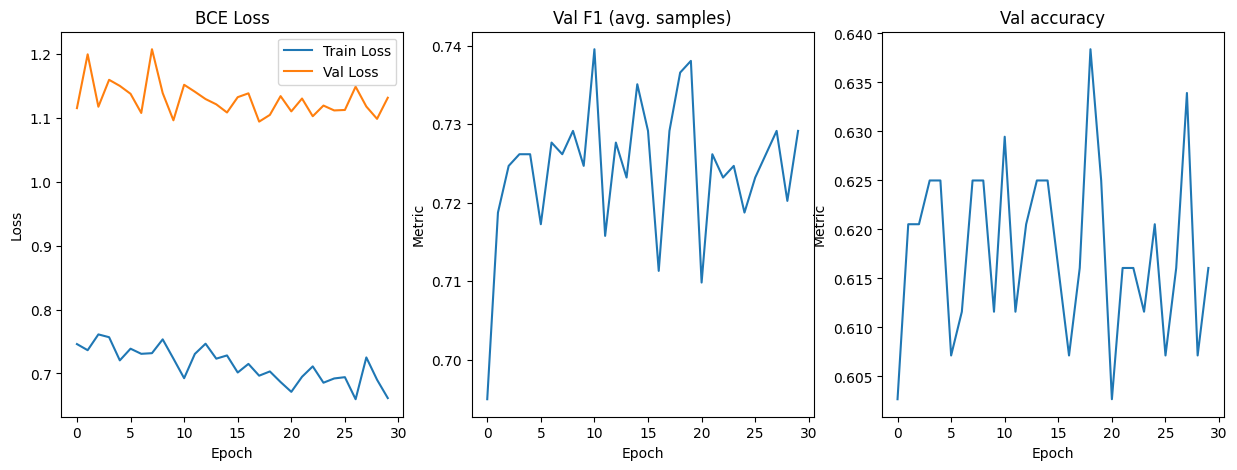

In [51]:
for i in range(3):
  optimizer = torch.optim.AdamW(model.model.classifier[1].parameters(), lr = 1e-3, weight_decay=1e-4)
  criterion = ClassBalancedLoss(train).to(device)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10, gamma=0.6)
  result = train_model(model, train, val, optimizer, criterion, epochs=30, stepLR=scheduler, checkpoint_name="efficientnet_tuned_classifer_cb.pt")

  ### Offsite test

In [52]:
model.load_state_dict(torch.load(checkpoints_dir + "efficientnet_tuned_classifer_cb.pt"))
eval_model(model, offsite_test, report=True)

100%|██████████| 7/7 [00:01<00:00,  6.03it/s]

              precision    recall  f1-score   support

           D       0.84      0.89      0.86       140
           G       0.77      0.55      0.64        49
           A       0.71      0.55      0.62        22

   micro avg       0.81      0.77      0.79       211
   macro avg       0.77      0.66      0.71       211
weighted avg       0.81      0.77      0.78       211
 samples avg       0.84      0.79      0.78       211



In [53]:
eval_model(model, onsite_test, "efficientnet_submission_classifier_cb.csv")

100%|██████████| 8/8 [00:01<00:00,  5.62it/s]


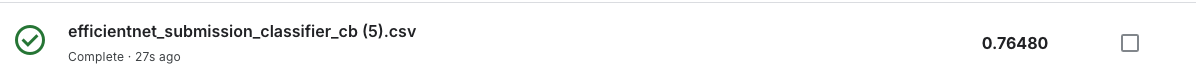

## Full fine-tuning

Only 3 epochs no more, usually overfits after epoch 1, lr = 1e-4 seem to be most optimal, no weight decay

Validation: 100%|██████████| 7/7 [00:01<00:00,  6.42it/s]


Epoch: 0 - Train Loss: 0.956234 - Val Loss: 1.399422 - Val Accuracy: 0.593750 - Val F1 (avg. samples): 0.721726
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]


Epoch: 1 - Train Loss: 0.353628 - Val Loss: 1.230839 - Val Accuracy: 0.660714 - Val F1 (avg. samples): 0.782738
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


Epoch: 2 - Train Loss: 0.207243 - Val Loss: 1.244859 - Val Accuracy: 0.665179 - Val F1 (avg. samples): 0.790179


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.46it/s]


Epoch: 3 - Train Loss: 0.212586 - Val Loss: 1.247607 - Val Accuracy: 0.669643 - Val F1 (avg. samples): 0.791667


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch: 4 - Train Loss: 0.158632 - Val Loss: 1.263107 - Val Accuracy: 0.660714 - Val F1 (avg. samples): 0.788690


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.48it/s]


Epoch: 5 - Train Loss: 0.168485 - Val Loss: 1.232415 - Val Accuracy: 0.669643 - Val F1 (avg. samples): 0.791667


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.30it/s]


Epoch: 6 - Train Loss: 0.195366 - Val Loss: 1.243164 - Val Accuracy: 0.665179 - Val F1 (avg. samples): 0.793155


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]


Epoch: 7 - Train Loss: 0.170571 - Val Loss: 1.233344 - Val Accuracy: 0.669643 - Val F1 (avg. samples): 0.791667


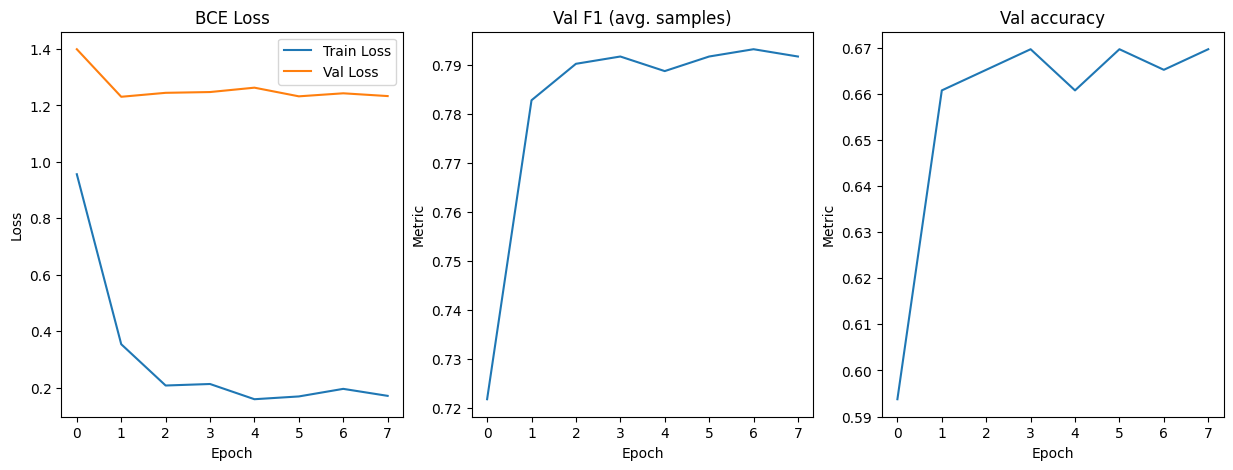

Validation: 100%|██████████| 7/7 [00:01<00:00,  6.35it/s]


Epoch: 0 - Train Loss: 0.405836 - Val Loss: 1.542588 - Val Accuracy: 0.678571 - Val F1 (avg. samples): 0.767857
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


Epoch: 1 - Train Loss: 0.233028 - Val Loss: 1.691066 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.752976


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.48it/s]


Epoch: 2 - Train Loss: 0.094413 - Val Loss: 1.575492 - Val Accuracy: 0.656250 - Val F1 (avg. samples): 0.763393


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.51it/s]


Epoch: 3 - Train Loss: 0.095236 - Val Loss: 1.602300 - Val Accuracy: 0.660714 - Val F1 (avg. samples): 0.764881


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.44it/s]


Epoch: 4 - Train Loss: 0.071825 - Val Loss: 1.551916 - Val Accuracy: 0.656250 - Val F1 (avg. samples): 0.763393


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.57it/s]


Epoch: 5 - Train Loss: 0.093262 - Val Loss: 1.504153 - Val Accuracy: 0.674107 - Val F1 (avg. samples): 0.772321
✅ Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.28it/s]


Epoch: 6 - Train Loss: 0.078157 - Val Loss: 1.511990 - Val Accuracy: 0.656250 - Val F1 (avg. samples): 0.763393


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


Epoch: 7 - Train Loss: 0.076910 - Val Loss: 1.508661 - Val Accuracy: 0.696429 - Val F1 (avg. samples): 0.776786


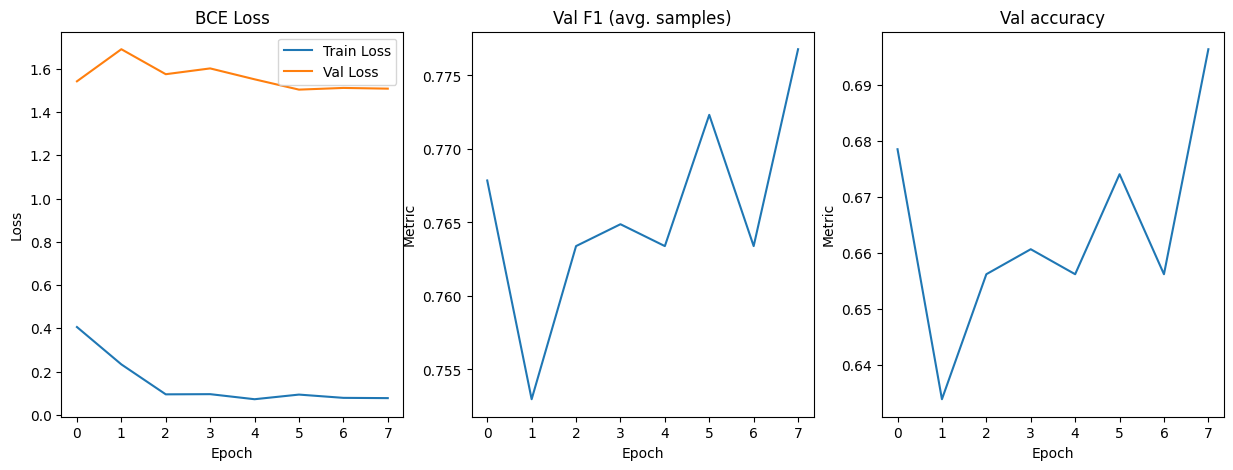

In [54]:
for layer in model.parameters():
  layer.requires_grad = True

for i in range(2):
  optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.3) #torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.3)
  result = train_model(model, train, val, optimizer=optimizer, criterion=criterion, epochs=8, stepLR=scheduler, checkpoint_name="efficientnet_cb.pt")

### Offsite

In [55]:
model.load_state_dict(torch.load(checkpoints_dir + "efficientnet_cb.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:01<00:00,  6.39it/s]

              precision    recall  f1-score   support

           D       0.86      0.89      0.88       140
           G       0.79      0.61      0.69        49
           A       0.71      0.55      0.62        22

   micro avg       0.83      0.79      0.81       211
   macro avg       0.79      0.68      0.73       211
weighted avg       0.83      0.79      0.81       211
 samples avg       0.84      0.81      0.81       211



### Onsite test
![](efficientnet_classifier_full.png)

In [56]:
eval_model(model, onsite_test, "efficientnet_submission_full_cb.csv")

100%|██████████| 8/8 [00:01<00:00,  5.58it/s]


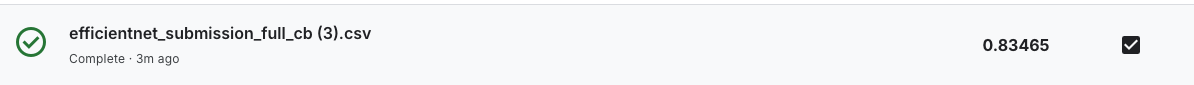